In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [11]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

In [12]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat

In [13]:
flx = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw.nc')
nc = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_heat.nc')
flx['heat'] = nc.heat

### Compare Labrador-Greenland throughflow with Davis and Hudson Strait

In [5]:
ConvFw_lsea_bnd = flx.sel(section='Labrador Greenland').fw - flx.sel(section='Hudson Strait').fw \
                    - flx.sel(section='Davis Strait').fw

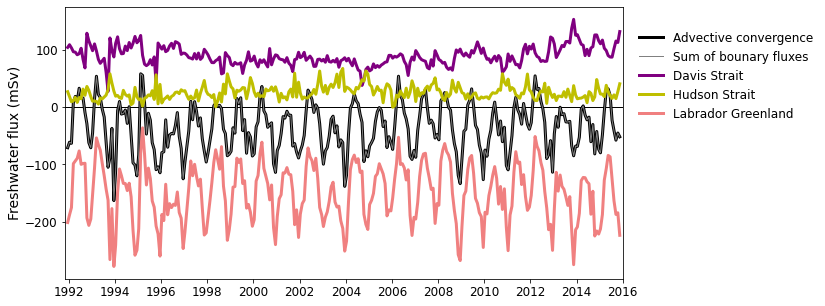

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw.time, budgFw.sel(region='lsea',term='adv_ConvFw')*1e3, lw=3, color='k',label='Advective convergence')
ax.plot(ConvFw_lsea_bnd.time, ConvFw_lsea_bnd*1e3, lw=1, color='grey',label='Sum of bounary fluxes')

ax.plot(flx.time,-flx.sel(section='Davis Strait').fw*1e3,lw=3,color='purple',linestyle='-',label='Davis Strait')
ax.plot(flx.time,-flx.sel(section='Hudson Strait').fw*1e3,lw=3,color='y',linestyle='-',label='Hudson Strait')
ax.plot(flx.time,flx.sel(section='Labrador Greenland').fw*1e3,lw=3,color='lightcoral',
        linestyle='-',label='Labrador Greenland')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
ax.legend(loc='upper left',bbox_to_anchor=(1.01, 0.95),frameon=False,fontsize=12)
#ax.invert_yaxis()

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [11]:
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
flx_anom = flx.groupby('time.month') - flx.groupby('time.month').mean('time')

In [12]:
df = pd.DataFrame({'time':budgFw_anom.time,
                   'total':budgFw_anom.sel(region='lsea',term='adv_ConvFw'),
                   'Labrador Greenland':flx_anom.sel(section='Labrador Greenland').fw,
                   'Davis Strait':-flx_anom.sel(section='Davis Strait').fw,
                   'Hudson Strait':-flx_anom.sel(section='Hudson Strait').fw})

In [13]:
df.set_index('time',inplace=True)

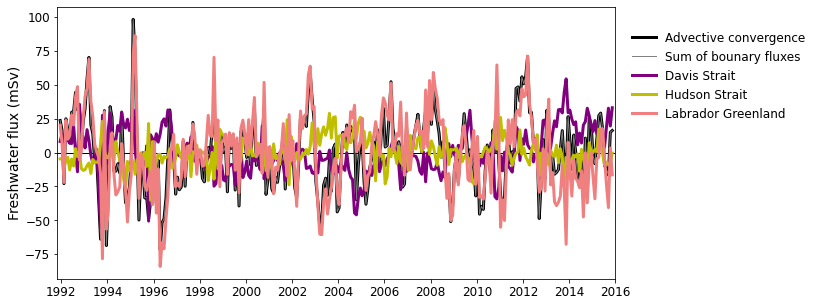

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(df.index, df.total*1e3, lw=3, color='k',label='Advective convergence')
ax.plot(df.index, df[['Labrador Greenland','Davis Strait','Hudson Strait']].sum(axis=1)*1e3,
        lw=1, color='grey',label='Sum of bounary fluxes')

ax.plot(df.index, df['Davis Strait']*1e3,lw=3,color='purple',linestyle='-',label='Davis Strait')
ax.plot(df.index, df['Hudson Strait']*1e3,lw=3,color='y',linestyle='-',label='Hudson Strait')
ax.plot(df.index, df['Labrador Greenland']*1e3,lw=3,color='lightcoral',
        linestyle='-',label='Labrador Greenland')

ax.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
ax.legend(loc='upper left',bbox_to_anchor=(1.01, 0.95),frameon=False,fontsize=12)
#ax.invert_yaxis()

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [12]:
df['dt'] = main.reset_coords().dt.to_dataframe().dt

In [13]:
# 6-month
df_sub = df.loc[(df.index > '1992-06-30')&(df.index <= '2016-01-01')]
df_6mo = df_sub.multiply(df_sub["dt"], axis="index").resample('6M',kind='period').sum().drop(columns=['dt'])

In [14]:
# Annual
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

In [15]:
# Pentad
df_sub = df.loc[(df.index > '1994-12-31')&(df.index < '2015-01-01')]
df_5yr = df_sub.multiply(df_sub["dt"], axis="index").resample('5A',kind='period').mean().drop(columns=['dt'])

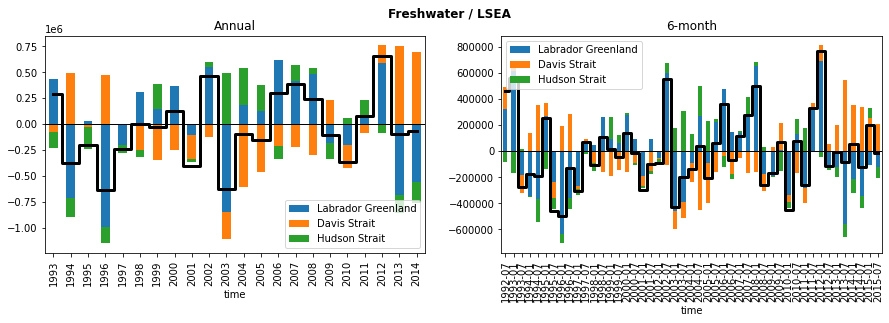

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

df_1yr.drop(columns=['total']).plot.bar(stacked=True,ax=axs[0])
axs[0].step(df_1yr.index.strftime('%y'), df_1yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].set_title('Annual')

#df_5yr.drop(columns=['total']).plot.bar(stacked=True,ax=axs[1])
#axs[1].step(df_5yr.index.strftime('%Y'), df_5yr.total, where='mid', c='k', lw=3, linestyle='-')
#axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
#axs[1].set_title('Pentad')
df_6mo.drop(columns=['total']).plot.bar(stacked=True,ax=axs[1])
axs[1].step(df_6mo.index.strftime('%Y-%m'), df_6mo.total, where='mid', c='k', lw=3, linestyle='-')
axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].set_title('6-month')

fig.suptitle('Freshwater / LSEA',fontweight='bold')

plt.show()

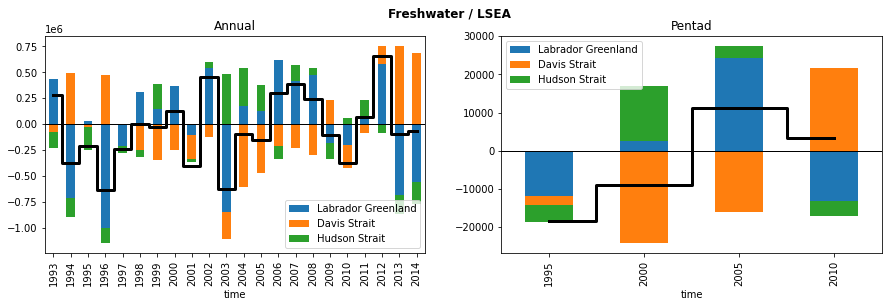

In [19]:
dt = main.dt.sel(time=slice('2013-01-01','2015-11-30'))

In [20]:
print('Adv. Conv. (LSEA, 2013 to 2015):',
      np.round((budgFw_anom.sel(region='lsea',
                         term='adv_ConvFw').sel(time=slice('2013-01-01','2015-11-30'))*dt).sum('time').values*1e-3,2),
      'km^3')
print('Labrador Greenland (2013 to 2015):',
      np.round((flx_anom.sel(time=slice('2013-01-01','2015-11-30'),
                             section='Labrador Greenland').fw*dt).sum('time').values*1e-3,2))
print('David Strait (2013 to 2015):',
      np.round((-flx_anom.sel(time=slice('2013-01-01','2015-11-30'),
                             section='Davis Strait').fw*dt).sum('time').values*1e-3,2))
print('Hudson Strait (2013 to 2015):',
      np.round((-flx_anom.sel(time=slice('2013-01-01','2015-11-30'),
                             section='Hudson Strait').fw*dt).sum('time').values*1e-3,2))
print('Total:',np.round(((flx_anom.sel(time=slice('2013-01-01','2015-11-30'),
                             section='Labrador Greenland').fw*dt).sum('time')\
                         -(flx_anom.sel(time=slice('2013-01-01','2015-11-30'),
                                        section='Davis Strait').fw*dt).sum('time')\
                         -(flx_anom.sel(time=slice('2013-01-01','2015-11-30'),
                              section='Hudson Strait').fw*dt).sum('time')).values*1e-3,2))

Adv. Conv. (LSEA, 2013 to 2015): 24.08 km^3
Labrador Greenland (2013 to 2015): -1465.58
David Strait (2013 to 2015): 1898.34
Hudson Strait (2013 to 2015): -390.23
Total: 42.52


In [21]:
print('Adv. Conv. (LSEA, 2013 to 2015):',
      np.round(budgFw_anom.sel(region='lsea',
                         term='adv_ConvFw').sel(time=slice('2013-01-01','2015-12-31')).mean('time').values*1e3,2),
      'mSv')
print('Labrador Greenland (2013 to 2015):',
      np.round(flx_anom.sel(time=slice('2013-01-01','2015-12-31'),
                             section='Labrador Greenland').fw.mean('time').values*1e3,2),'mSv')
print('David Strait (2013 to 2015):',
      np.round(-flx_anom.sel(time=slice('2013-01-01','2015-12-31'),
                             section='Davis Strait').fw.mean('time').values*1e3,2),'mSv')
print('Hudson Strait (2013 to 2015):',
      np.round(-flx_anom.sel(time=slice('2013-01-01','2015-12-31'),
                             section='Hudson Strait').fw.mean('time').values*1e3,2),'mSv')
print('Total:',np.round((flx_anom.sel(time=slice('2013-01-01','2015-12-31'),
                             section='Labrador Greenland').fw.mean('time')\
                -flx_anom.sel(time=slice('2013-01-01','2015-12-31'),
                              section='Davis Strait').fw.mean('time')\
                -flx_anom.sel(time=slice('2013-01-01','2015-12-31'),
                              section='Hudson Strait').fw.mean('time')).values*1e3,2),'mSv')

Adv. Conv. (LSEA, 2013 to 2015): 0.76 mSv
Labrador Greenland (2013 to 2015): -15.9 mSv
David Strait (2013 to 2015): 20.96 mSv
Hudson Strait (2013 to 2015): -4.12 mSv
Total: 0.95 mSv


### Mean trasnports

In [14]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

In [15]:
import ecco_v4_py as ecco

### Calculate freshwater fluxes

In [16]:
# Reference salinity
Sref = 35.0

In [17]:
grid = ecco.get_llc_grid(main)

In [18]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [19]:
# Freshwater advective (Eulerian) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

In [20]:
def get_FWflux(section):
    pt1,pt2 = ecco.get_section_endpoints(section)
    maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)
    
    sec_FWtrsp_x = (ADVx_FW * maskW).sum(dim=['tile'])
    sec_FWtrsp_y = (ADVy_FW * maskS).sum(dim=['tile'])
    
    sec_FWtrsp_x_anom = sec_FWtrsp_x.groupby('time.month') - sec_FWtrsp_x.groupby('time.month').mean('time')
    sec_FWtrsp_y_anom = sec_FWtrsp_y.groupby('time.month') - sec_FWtrsp_y.groupby('time.month').mean('time')
    
    sec_x = sec_FWtrsp_x.sum('k').compute()*Sv
    sec_y = sec_FWtrsp_y.sum('k').compute()*Sv
    
    sec_x_anom = sec_FWtrsp_x_anom.sel(time=slice('2013-01-01','2015-12-31')).sum('k').compute()*Sv
    sec_y_anom = sec_FWtrsp_y_anom.sel(time=slice('2013-01-01','2015-12-31')).sum('k').compute()*Sv
    
    j = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().j.values
    
    i_g = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().i_g.values
    
    j_g = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().j_g.values
    
    i = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().i.values
    
    if j.size == 0:
        sec_x_mean = np.array([])
        sec_x_anom_mean = np.array([])
    else:
        sec_x_mean = sec_x.mean('time').values[j,i_g]*1e3
        sec_x_anom_mean = sec_x_anom.mean('time').values[j,i_g]*1e3
    
    if i.size == 0:
        sec_y_mean = np.array([])
        sec_y_anom_mean = np.array([])
    else:
        sec_y_mean = sec_y.mean('time').values[j_g,i]*1e3
        sec_y_anom_mean = sec_y_anom.mean('time').values[j_g,i]*1e3

    return sec_x_mean, sec_y_mean, sec_x_anom_mean, sec_y_anom_mean

In [21]:
def get_coords(section):
    
    pt1,pt2 = ecco.get_section_endpoints(section)
    maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)
    
    j = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().j.values
    
    i_g = maskW[10].where((maskW[10].values!=0)&(main.hFacW[0,10].values==1))\
            .to_dataframe(name='maskW').dropna().reset_index().i_g.values
    
    j_g = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().j_g.values
    
    i = maskS[10].where((maskS[10].values!=0)&(main.hFacS[0,10].values==1))\
            .to_dataframe(name='maskS').dropna().reset_index().i.values
    
    if j.size == 0:
        xc = np.array([])
        yg = np.array([])
    else:
        xc = main.XC.isel(tile=10).values[j,i_g]
        yg = main.YG.isel(tile=10).values[j,i_g]
    
    if i.size == 0:
        xg = np.array([])
        yc = np.array([])
    else:
        xg = main.XG.isel(tile=10).values[j_g,i]
        yc = main.YC.isel(tile=10).values[j_g,i]
    
    return xc, yg, xg, yc

In [22]:
lgx,lgy,lgx_anom,lgy_anom = get_FWflux('Labrador Greenland')
lg_xc,lg_yg,lg_xg,lg_yc = get_coords('Labrador Greenland')

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [23]:
dsx, dsy, dsx_anom, dsy_anom = get_FWflux('Davis Strait')
ds_xc,ds_yg,ds_xg,ds_yc = get_coords('Davis Strait')

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [24]:
hsx,hsy,hsx_anom,hsy_anom = get_FWflux('Hudson Strait')
hs_xc,hs_yg,hs_xg,hs_yc = get_coords('Hudson Strait')

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [5]:
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]

In [28]:
import cmocean.cm as cmo

In [2]:
import cartopy
import sys
import os
os.environ['CARTOPY_USER_BACKGROUNDS'] = '/mnt/efs/cartopy/bg'

In [27]:
import matplotlib.ticker as mticker

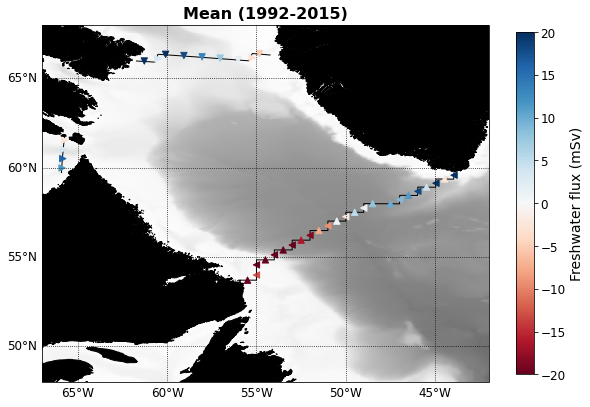

In [32]:
fig = plt.figure(figsize=[10, 7])

ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_title(r'Mean (1992-2015)', fontsize=16, fontweight='bold')
ax.set_extent([-67, -42, 48, 68], cartopy.crs.PlateCarree())
ax.background_img(name='BTg', resolution='high')
ax.add_feature(cartopy.feature.GSHHSFeature(scale = 'intermediate', edgecolor='k',facecolor='k'))

gl = ax.gridlines(linestyle=':',color='k', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,5))
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}

ax.plot(coords_DaS[0::2], coords_DaS[1::2], color='k',ls='-',lw=1,transform=cartopy.crs.PlateCarree(),zorder=1)
ax.plot(coords_HS[0::2], coords_HS[1::2], color='k',ls='-',lw=1,transform=cartopy.crs.PlateCarree(),zorder=1)
ax.plot(coords_LG[0::2], coords_LG[1::2], color='k',ls='-',lw=1,transform=cartopy.crs.PlateCarree(),zorder=1)

p = ax.scatter(lg_xc, lg_yg, c=lgx, vmin=-20, vmax=20, cmap='RdBu', marker='^', s=40,
           transform=cartopy.crs.PlateCarree(), zorder=2)
p = ax.scatter(lg_xg, lg_yc, c=lgy, vmin=-20, vmax=20, cmap='RdBu', marker='<', s=40,
           transform=cartopy.crs.PlateCarree(), zorder=2)
p = ax.scatter(ds_xc, ds_yg, c=-dsx, vmin=-20, vmax=20, cmap='RdBu', marker='v', s=40,
           transform=cartopy.crs.PlateCarree(), zorder=2)
p = ax.scatter(ds_xg, ds_yc, c=-dsy, vmin=-20, vmax=20, cmap='RdBu', marker='>', s=40,
           transform=cartopy.crs.PlateCarree(), zorder=2)
p = ax.scatter(hs_xg, hs_yc, c=-hsy, vmin=-20, vmax=20, cmap='RdBu', marker='>', s=40,
           transform=cartopy.crs.PlateCarree(), zorder=2)

cbar = fig.colorbar(p, orientation='vertical', shrink=0.9, ticks=np.arange(-20,25,5))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Freshwater flux (mSv)', fontsize=14)

plt.savefig('/mnt/efs/figure.png')
plt.show()

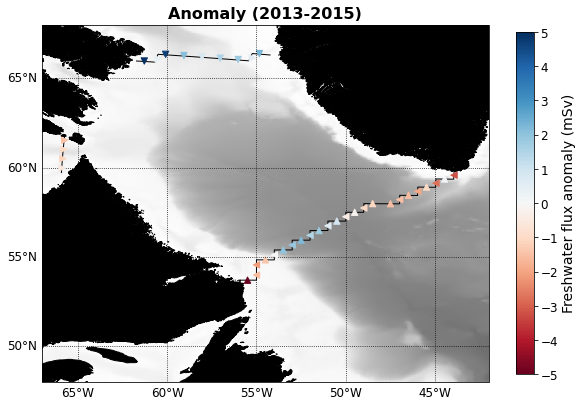

In [33]:
fig = plt.figure(figsize=[10, 7])

ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_title(r'Anomaly (2013-2015)', fontsize=16, fontweight='bold')
ax.set_extent([-67, -42, 48, 68], cartopy.crs.PlateCarree())
ax.background_img(name='BTg', resolution='high')
ax.add_feature(cartopy.feature.GSHHSFeature(scale = 'intermediate', edgecolor='k',facecolor='k'))

gl = ax.gridlines(linestyle=':',color='k', draw_labels=True)
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,5))
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style= {'size': 12, 'color': 'k'}
gl.ylabel_style= {'size': 12, 'color': 'k'}

ax.plot(coords_DaS[0::2], coords_DaS[1::2], color='k',ls='-',lw=1,transform=cartopy.crs.PlateCarree(),zorder=1)
ax.plot(coords_HS[0::2], coords_HS[1::2], color='k',ls='-',lw=1,transform=cartopy.crs.PlateCarree(),zorder=1)
ax.plot(coords_LG[0::2], coords_LG[1::2], color='k',ls='-',lw=1,transform=cartopy.crs.PlateCarree(),zorder=1)

p = ax.scatter(lg_xc, lg_yg, c=lgx_anom, vmin=-5, vmax=5, cmap='RdBu', marker='^', s=40,
               transform=cartopy.crs.PlateCarree(), zorder=2)
p = ax.scatter(lg_xg, lg_yc, c=lgy_anom, vmin=-5, vmax=5, cmap='RdBu', marker='<', s=40,
               transform=cartopy.crs.PlateCarree(), zorder=3)
p = ax.scatter(ds_xc, ds_yg, c=-dsx_anom, vmin=-5, vmax=5, cmap='RdBu', marker='v', s=40,
               transform=cartopy.crs.PlateCarree(), zorder=2)
p = ax.scatter(ds_xg, ds_yc, c=-dsy_anom, vmin=-5, vmax=5, cmap='RdBu', marker='>', s=40,
               transform=cartopy.crs.PlateCarree(), zorder=3)
p = ax.scatter(hs_xg, hs_yc, c=-hsy_anom, vmin=-5, vmax=5, cmap='RdBu', marker='>', s=40,
               transform=cartopy.crs.PlateCarree(), zorder=3)


cbar = fig.colorbar(p, orientation='vertical', shrink=0.9, ticks=np.arange(-5,6,1))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Freshwater flux anomaly (mSv)', fontsize=14)

plt.savefig('/mnt/efs/figure.png')
plt.show()

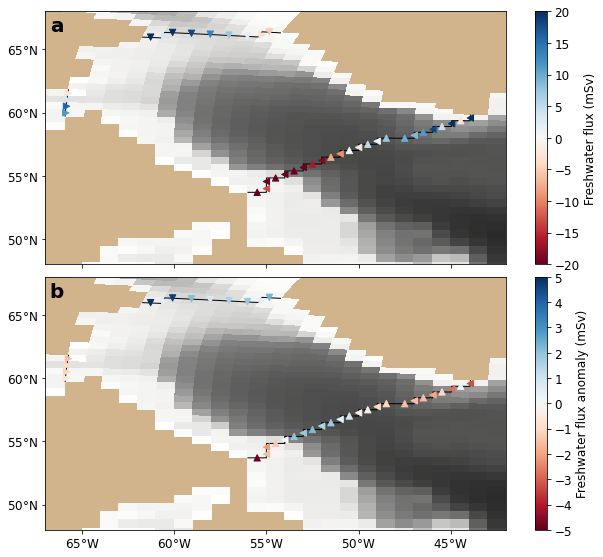

In [20]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 9))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05, wspace=0.03)

#axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].text(0.01,0.92, 'a', fontsize=20, fontweight='bold', transform=axs[0].transAxes)

main.Depth[10].where(main.hFacC[0,10].values==1).plot(ax=axs[0], x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.gray_r,zorder=0)

axs[0].plot(coords_DaS[0::2], coords_DaS[1::2], color='k',ls='-',lw=1,zorder=1)
axs[0].plot(coords_HS[0::2], coords_HS[1::2], color='k',ls='-',lw=1,zorder=1)
axs[0].plot(coords_LG[0::2], coords_LG[1::2], color='k',ls='-',lw=1,zorder=1)

p = axs[0].scatter(lg_xc, lg_yg, c=lgx, vmin=-20, vmax=20, cmap='RdBu', marker='^', s=40, zorder=2)
p = axs[0].scatter(lg_xg, lg_yc, c=lgy, vmin=-20, vmax=20, cmap='RdBu', marker='<', s=40, zorder=2)
p = axs[0].scatter(ds_xc, ds_yg, c=-dsx, vmin=-20, vmax=20, cmap='RdBu', marker='v', s=40, zorder=2)
p = axs[0].scatter(ds_xg, ds_yc, c=-dsy, vmin=-20, vmax=20, cmap='RdBu', marker='>', s=40, zorder=2)
p = axs[0].scatter(hs_xg, hs_yc, c=-hsy, vmin=-20, vmax=20, cmap='RdBu', marker='>', s=40, zorder=2)

axs[0].set_xlim([-67,-42])
axs[0].set_ylim([48,68])
axs[0].set_xticks(np.arange(-65,-40,5))
axs[0].set_yticks(np.arange(50,70,5))
axs[0].set_facecolor('tan')
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title('')
axs[0].set_yticklabels((r'${:.0f}\degree$N'.format(_) for _ in np.arange(50,70,5)), fontsize=12)

cbar = fig.colorbar(p, ax=axs[0], ticks=np.arange(-20,25,5))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Freshwater flux (mSv)', fontsize=12)

#axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].text(0.01,0.92, 'b', fontsize=20, fontweight='bold', transform=axs[1].transAxes)

main.Depth[10].where(main.hFacC[0,10].values==1).plot(ax=axs[1], x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.gray_r,zorder=0)

axs[1].plot(coords_DaS[0::2], coords_DaS[1::2], color='k',ls='-',lw=1,zorder=1)
axs[1].plot(coords_HS[0::2], coords_HS[1::2], color='k',ls='-',lw=1,zorder=1)
axs[1].plot(coords_LG[0::2], coords_LG[1::2], color='k',ls='-',lw=1,zorder=1)

p = axs[1].scatter(lg_xc, lg_yg, c=lgx_anom, vmin=-5, vmax=5, cmap='RdBu', marker='^', s=40, zorder=2)
p = axs[1].scatter(lg_xg, lg_yc, c=lgy_anom, vmin=-5, vmax=5, cmap='RdBu', marker='<', s=40, zorder=3)
p = axs[1].scatter(ds_xc, ds_yg, c=-dsx_anom, vmin=-5, vmax=5, cmap='RdBu', marker='v', s=40, zorder=2)
p = axs[1].scatter(ds_xg, ds_yc, c=-dsy_anom, vmin=-5, vmax=5, cmap='RdBu', marker='>', s=40, zorder=3)
p = axs[1].scatter(hs_xg, hs_yc, c=-hsy_anom, vmin=-5, vmax=5, cmap='RdBu', marker='>', s=40, zorder=3)

axs[1].set_xlim([-67,-42])
axs[1].set_ylim([48,68])
axs[1].set_xticks(np.arange(-65,-40,5))
axs[1].set_yticks(np.arange(50,70,5))
axs[1].set_facecolor('tan')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title('')
axs[1].set_xticklabels((r'${:.0f}\degree$W'.format(_) for _ in np.arange(-65,-40,5)*-1), fontsize=12)
axs[1].set_yticklabels((r'${:.0f}\degree$N'.format(_) for _ in np.arange(50,70,5)), fontsize=12)

cbar = fig.colorbar(p, ax=axs[1], ticks=np.arange(-5,6,1))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Freshwater flux anomaly (mSv)', fontsize=12)

plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

### Check for one section

In [7]:
pt1,pt2 = ecco.get_section_endpoints('Labrador Greenland')

maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

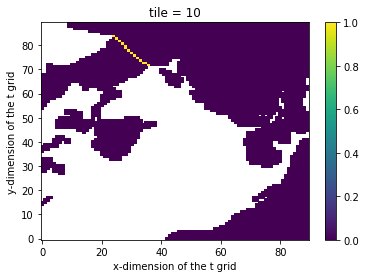

In [8]:
maskC[10].where(main.hFacC[0,10].values==1).plot()

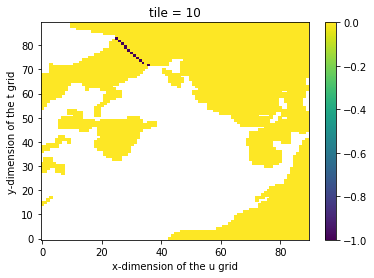

In [26]:
maskW[10].where(main.hFacW[0,10].values==1).plot()

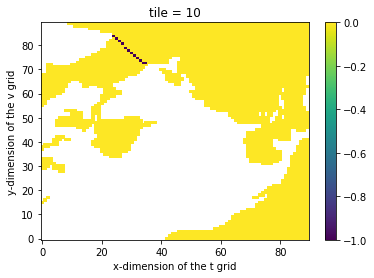

In [27]:
maskS[10].where(main.hFacS[0,10].values==1).plot()

### Grid area along section

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [28]:
# Cell area along y at u location (m^2)
dyA = main.dyG*main.drF*main.hFacW

# Cell area along x at v location (m^2)
dxA = main.dxG*main.drF*main.hFacS

In [30]:
# Get area for strait
dyA_LG = dyA*maskW*-1
dxA_LG = dxA*maskS*-1

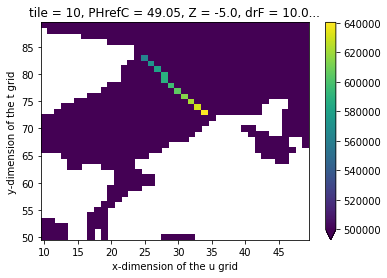

In [34]:
dyA_LG[10,:,:,0].where(main.hFacS[0,10].values==1)[50:90,10:50].plot(vmin=5e5)

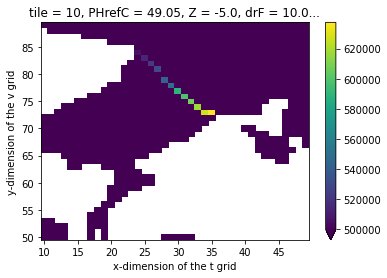

In [33]:
dxA_LG[10,:,:,0].where(main.hFacS[0,10].values==1)[50:90,10:50].plot(vmin=5e5)

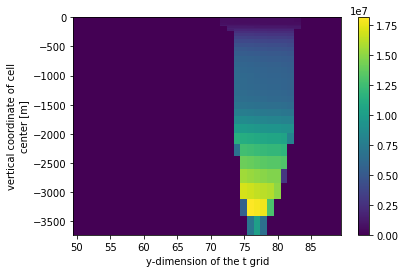

In [51]:
dyA_LG.sum(dim=['i_g','tile'])[50:90,:44].T.swap_dims({'k':'Z'}).plot()

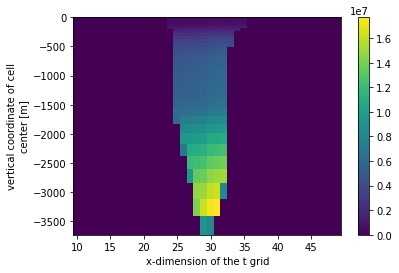

In [47]:
dxA_LG.sum(dim=['j_g','tile'])[10:50,:44].T.swap_dims({'k':'Z'}).plot()

In [52]:
sec_area_x = dyA_LG.sum(dim=['i_g','j','tile'])
sec_area_y = dxA_LG.sum(dim=['i','j_g','tile'])

In [53]:
# Section area (m^2)
sec_area = (sec_area_x + sec_area_y).sum('k').compute()

print('Area across the strait:',np.round(sec_area.values/1e6),'km^2')

Area across the strait: 3091.0 km^2


### Volume flux

In [54]:
u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

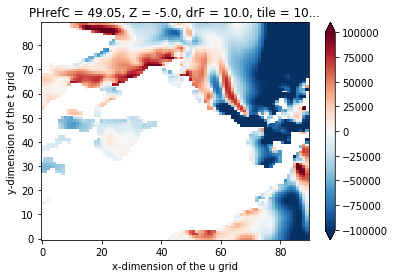

In [55]:
u_transport[:,0,10].mean('time').where(main.hFacW[0,10].values==1).plot(vmin=-1e5)

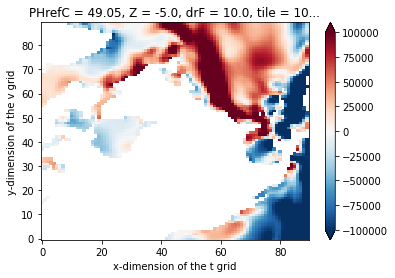

In [56]:
v_transport[:,0,10].mean('time').where(main.hFacS[0,10].values==1).plot(vmin=-1e5)

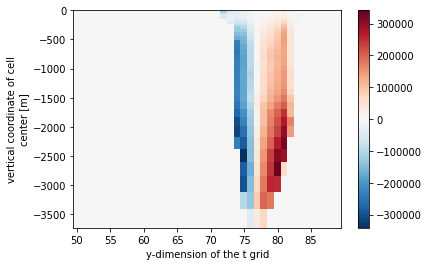

In [86]:
(u_transport * maskW).sum(dim=['i_g','tile']).mean('time')[:44,50:90].swap_dims({'k':'Z'}).plot()

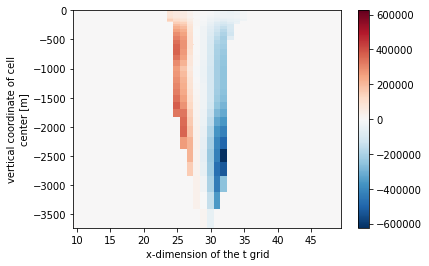

In [87]:
(v_transport * maskS).sum(dim=['j_g','tile']).mean('time')[:44,10:50].swap_dims({'k':'Z'}).plot()

In [88]:
# Volume transports
sec_trsp_x = (u_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (v_transport * maskS).sum(dim=['i','j_g','tile'])

In [89]:
sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv

print('Vol. flux (1992-2015):', 
      np.round(sec_trsp.mean('time').values,2),'±',np.round(2*sec_trsp.std('time').values,2),'Sv')

Vol. flux (1992-2015): -1.61 ± 0.63 Sv


In [ ]:
pt1,pt2 = ecco.get_section_endpoints('Labrador Greenland')
maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)
sec_FWtrsp_x = (ADVx_FW * maskW).sum(dim=['tile'])
sec_FWtrsp_y = (ADVy_FW * maskS).sum(dim=['tile'])
sec_FWtrsp_x_anom = sec_FWtrsp_x.groupby('time.month') - sec_FWtrsp_x.groupby('time.month').mean('time')
sec_FWtrsp_y_anom = sec_FWtrsp_y.groupby('time.month') - sec_FWtrsp_y.groupby('time.month').mean('time')
lgx = sec_FWtrsp_x.sum('k').compute()*Sv
lgy = sec_FWtrsp_y.sum('k').compute()*Sv
lgx_anom = sec_FWtrsp_x_anom.sel(time=slice('2013-01-01','2015-12-31')).sum('k').compute()*Sv
lgy_anom = sec_FWtrsp_y_anom.sel(time=slice('2013-01-01','2015-12-31')).sum('k').compute()*Sv

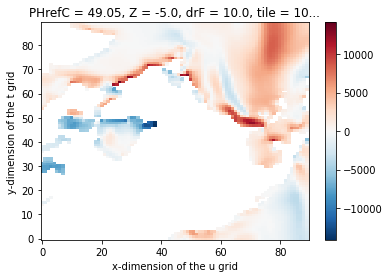

In [95]:
ADVx_FW[:,0,10].mean('time').where(main.hFacW[0,10].values==1).plot()

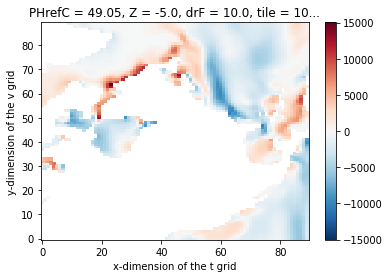

In [96]:
ADVy_FW[:,0,10].mean('time').where(main.hFacS[0,10].values==1).plot()

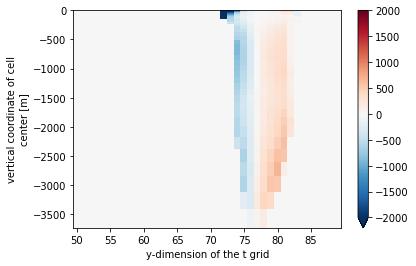

In [99]:
(ADVx_FW * maskW).sum(dim=['i_g','tile']).mean('time')[:44,50:90].swap_dims({'k':'Z'}).plot(vmin=-2000)

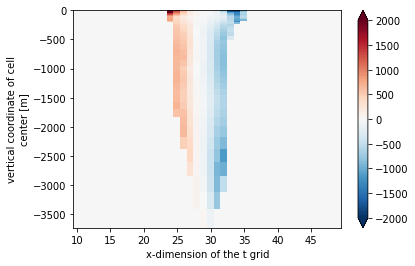

In [100]:
(ADVy_FW * maskS).sum(dim=['j_g','tile']).mean('time')[:44,10:50].swap_dims({'k':'Z'}).plot(vmin=-2000)

In [101]:
# Freshwater transports
sec_trsp_x = (ADVx_FW * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (ADVy_FW * maskS).sum(dim=['i','j_g','tile'])

In [102]:
# Freshwater transport (Sv)
sec_FWtrsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv

print('FW flux (Sref =',Sref, '/ 1992-2015):', 
      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')

FW flux (Sref = 35.0 / 1992-2015): -152.3 ± 99.2 mSv


In [163]:
sec_FWtrsp_x = (ADVx_FW * maskW).sum(dim=['tile'])
sec_FWtrsp_y = (ADVy_FW * maskS).sum(dim=['tile'])

sec_area_x = dyA_LG.sum(dim=['tile'])
sec_area_y = dxA_LG.sum(dim=['tile'])

In [178]:
secFWvel_x = sec_FWtrsp_x/sec_area_x
secFWvel_y = sec_FWtrsp_y/sec_area_y

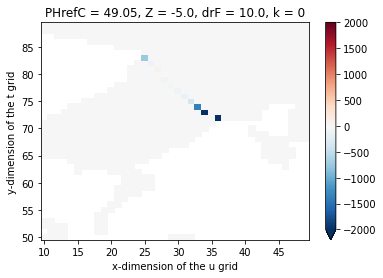

In [144]:
sec_FWtrsp_x.mean('time').where(main.hFacW[:,10].values==1)[0,50:90,10:50].plot(vmin=-2000)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


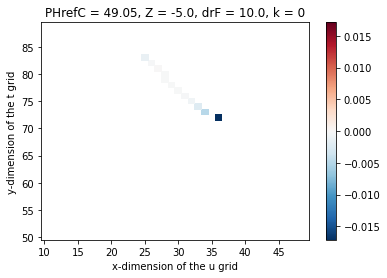

In [179]:
secFWvel_x.mean('time').where(main.hFacW[:,10].values==1)[0,50:90,10:50].plot()

In [183]:
main.hFacW[:,10]

<xarray.DataArray 'hFacW' (k: 50, j: 90, i_g: 90)>
dask.array<getitem, shape=(50, 90, 90), dtype=float32, chunksize=(50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
    PHrefC   (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drF      (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
    tile     int64 10
    hFacW    (k, j, i_g) float32 dask.array<chunksize=(50, 90, 90), meta=np.ndarray>
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    rAw      (j, i_g) float32 dask.array<chunksize=(90, 90), meta=np.ndarray>
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction_at_u_location

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


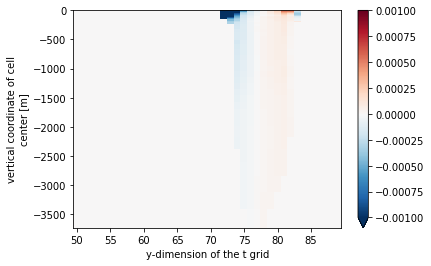

In [186]:
secFWvel_x.sum(dim=['i_g']).mean('time')[:44,50:90].swap_dims({'k':'Z'}).plot(vmin=-0.001)

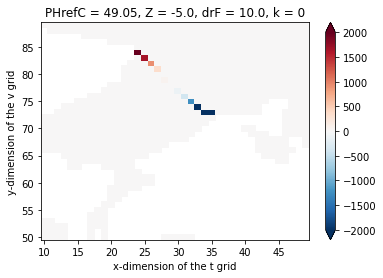

In [150]:
sec_FWtrsp_y.mean('time').where(main.hFacS[:,10].values==1)[0,50:90,10:50].plot(vmin=-2000)

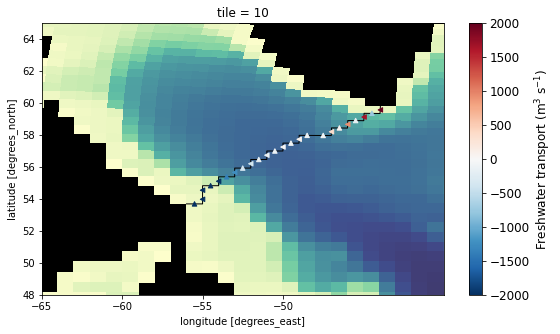

In [153]:
fig, ax = plt.subplots(figsize=(9,5))

main.Depth[10].where(main.hFacC[0,10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.deep,zorder=0)
plt.plot(coords_LG[0::2], coords_LG[1::2], color='k',ls='-',lw=1,zorder=1)

p = plt.scatter(main.XC.isel(tile=10).values[j,i_g],main.YG.isel(tile=10).values[j,i_g],
                c=sec_FWtrsp_x.mean('time').values[0,j,i_g], vmin=-2000, vmax=2000, cmap='RdBu_r', 
                marker='^', s=20, zorder=2)
p = plt.scatter(main.XG.isel(tile=10).values[j_g,i],main.YC.isel(tile=10).values[j_g,i],
                c=sec_FWtrsp_y.mean('time').values[0,j_g,i], vmin=-2000, vmax=2000, cmap='RdBu_r', 
                marker='<', s=20, zorder=3)

ax.set_xlim([-65,-40])
ax.set_ylim([48,65])
ax.set_xticks(np.arange(-65,-45,5))
ax.set_yticks(np.arange(48,66,2))
ax.set_facecolor('k')

cbar = fig.colorbar(p, ax=ax, ticks=np.arange(-2000,2500,500))
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Freshwater transport (m$^3$ s$^{-1}$)', fontsize=12)
plt.show()

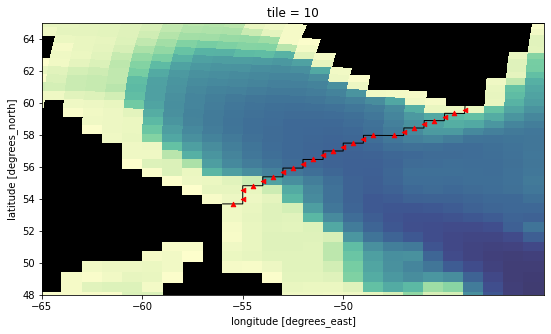

In [135]:
fig, ax = plt.subplots(figsize=(9,5))

main.Depth[10].where(main.hFacC[0,10].values==1).plot(ax=ax, x='XC', y='YC', add_colorbar=False,
                                                      vmin=0, vmax=5400, cmap=cmo.deep,zorder=0)
plt.plot(coords_LG[0::2], coords_LG[1::2], color='k',ls='-',lw=1,zorder=1)

plt.scatter(main.XC.isel(tile=10).values[j,i_g],main.YG.isel(tile=10).values[j,i_g],
         c='r',marker='^',s=20,zorder=2)
plt.scatter(main.XG.isel(tile=10).values[j_g,i],main.YC.isel(tile=10).values[j_g,i],
         c='r',marker='<',s=20,zorder=3)

ax.set_xlim([-65,-40])
ax.set_ylim([48,65])
ax.set_xticks(np.arange(-65,-45,5))
ax.set_yticks(np.arange(48,66,2))

ax.set_facecolor('k')
plt.show()

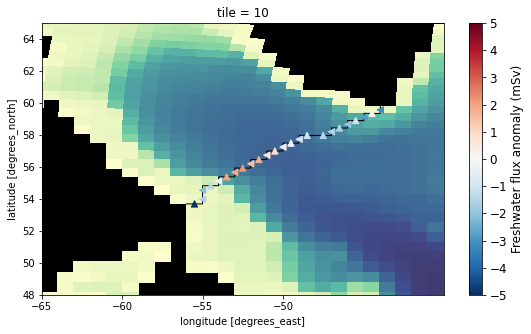

### Save values to project

In [177]:
secFWvel_x[0,0].values[j,i_g]

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


array([-1.74413452e-02, -4.93500052e-03, -1.26498727e-03, -4.07889394e-04,
       -5.64300671e-04, -4.62622864e-04, -4.15198662e-04, -3.74083275e-04,
       -2.65596546e-04, -9.04423841e-05, -2.66440664e-04, -5.10570047e-04])

In [161]:
sec_FWtrsp_x[0,0].values[j,i_g]

array([-11482.0234375 ,  -3160.38574219,   -798.91235352,   -254.03083801,
         -346.54388428,   -280.12548828,   -248.03495789,   -220.40046692,
         -156.49630737,    -52.53175735,   -152.45210266,   -287.56188965])

In [167]:
sec_area_x[:,:,0].values[j,i_g]

array([658322.125 , 640402.3125, 631557.625 , 622793.4375, 614112.125 ,
       605515.875 , 597388.625 , 589174.875 , 589225.6875, 580831.1875,
       572180.3125, 563217.3125])

In [160]:
main.XC[10].values[j,i_g]

array([-55.5     , -54.5     , -53.5     , -52.5     , -51.5     ,
       -50.5     , -49.499283, -48.49387 , -47.49429 , -46.485313,
       -45.473763, -44.46124 ], dtype=float32)

In [162]:
main.YG[10].values[j,i_g]

array([53.69125 , 54.829044, 55.384766, 55.931786, 56.470177, 57.      ,
       57.494728, 57.978825, 57.972424, 58.443645, 58.905373, 59.35802 ],
      dtype=float32)

In [157]:
sec_FWtrsp_y[:,:,j_g,i]

<xarray.DataArray (time: 288, k: 50, j_g: 12, i: 12)>
dask.array<getitem, shape=(288, 50, 12, 12), dtype=float64, chunksize=(1, 50, 12, 12), chunktype=numpy.ndarray>
Coordinates:
    PHrefC   (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drF      (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dt       (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
  * i        (i) int64 34 35 33 32 31 30 29 28 27 26 25 24
    iter     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j_g      (j_g) int64 73 73 74 75 76 77 78 79 81 82 83 84
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14T12:00:00